In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, invgamma, invwishart, wishart
import pickle
import sys

In [2]:
import os

In [5]:
sd1 = 18
sd2 = 0.1
os.path.exists(f'results/mvn_sd1_{sd1}_sd2_{sd2}')

True

# Sample from a Gaussian mixture model and from a multivariate normal
A Gaussian mixture model (GMM) is a blend of 2 Gaussians at 2 different means with different standard deviations. The probability density of a GMM with 2 components is
$$
p(x|\mu_1,\mu_2,\sigma_1, \sigma_2,\pi_1,\pi_2)=\pi_1 \mathcal N(x|\mu_1, \sigma_1)+\pi_2 \mathcal N(x|\mu_2, \sigma_2)
$$
$\pi_1,\pi_2$ are the mixing weights, denoting how much weight we give each component.

$\mu_1,\mu_2$ are the means: a list of 2 vectors

$\sigma_1, \sigma_2$ are the covariances: a list of 2 matrices

We can sample from a GMM by:
1) Sampling from a multinomial distribution: This gives us a list of which component to sample from 

2) Given the list of components to sample from, sample from the corresponding multivariate normal (with the given mean and covariance)


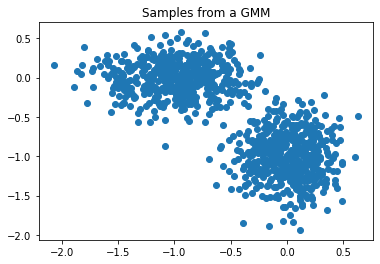

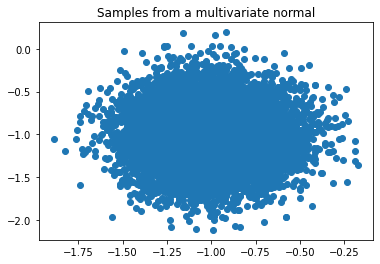

In [2]:
def sample_gmm(means, covars, 
               n_samples = 1000, 
               weights = [0.5,0.5]):
    rng = np.random.mtrand._rand
    n_samples_comp = rng.multinomial(n_samples, weights)
    dat = np.vstack([
                rng.multivariate_normal(mean, covariance, int(sample))
                for (mean, covariance, sample) in zip(
                    means, covars, n_samples_comp)])
    return dat
    
def sample_mvn(mean, cov, n_samples = 10000):
    rng = np.random.mtrand._rand
    dat = rng.multivariate_normal(mean, cov, n_samples)
    return dat
    
means = np.array([[0,-1], [-1,0]])
cov1 = np.diag([1,2])/20
cov2 = np.diag([2,1])/20
#precisions = [np.linalg.inv(cov1), np.linalg.inv(cov2)]
covars = [cov1, cov2]
dat = sample_gmm(means, covars)
plt.scatter(dat[:,0],dat[:,1])
plt.title("Samples from a GMM")
plt.show()
dat = sample_mvn([-1, -1], cov1)
plt.scatter(dat[:,0],dat[:,1])
plt.title("Samples from a multivariate normal")
plt.show()


Given a dataset $X=\{x_1,x_2,\ldots, x_N\}$, the log-probability of the dataset under the GMM is
$$
\begin{aligned}&
p(X|\mu_1,\mu_2,\sigma_1, \sigma_2,\pi_1,\pi_2)=\prod _{i=1}^N \pi_1 \mathcal N(x_i|\mu_1, \sigma_1)+\pi_2 \mathcal N(x_i|\mu_2, \sigma_2)\\
& \Rightarrow \log p(X|\mu_1,\mu_2,\sigma_1, \sigma_2,\pi_1,\pi_2)\\
& \mkern50mu = \sum  _{i=1}^N \log \left (  \pi_1 \mathcal N(x_i|\mu_1, \sigma_1)+\pi_2 \mathcal N(x_i|\mu_2, \sigma_2)\right ) 
\end{aligned} 
$$

The log-probability of the dataset $X=\{x_1,x_2,\ldots, x_N\}$ under the multivariate normal is
\begin{aligned}&
p(X|\mu , \sigma )=\prod _{i=1}^N   \mathcal N(x_i|\mu , \sigma) \\
& \Rightarrow \log p(X|\mu , \sigma )  = \sum  _{i=1}^N \log  \mathcal N(x_i|\mu , \sigma)
\end{aligned} 

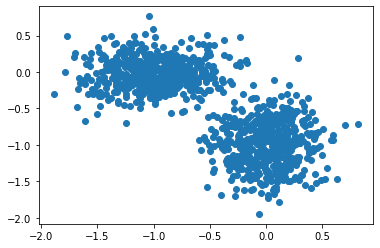

The likelihood of this dataset (in figure) under a mixture model is -892.8186174075544
The likelihood of this dataset (in figure) under a multivariate normal model is -7867.9724624897435


In [3]:
def compute_logdensity_gmm(dat, means, covars,  
               weights = [0.5,0.5]):
    comp0 = multivariate_normal(means[0], covars[0])
    comp1 = multivariate_normal(means[1], covars[1])
    llh = 0.0
    for x in (dat):
        w = [weights[idx] * (comp.pdf(x))
                 for idx, comp in enumerate([comp0, comp1])]
        sum_ = np.sum(w)
        l = np.log(sum_)
        llh += l
    return llh

def compute_logdensity_mvn(dat, mean, covar):
    comp0 = multivariate_normal(mean, covar)
    llh = np.sum(np.log(comp0.pdf(dat)))
    return (llh)
means = np.array([[0,-1], [-1,0]])
cov1 = np.diag([1,2])/20
cov2 = np.diag([2,1])/20
covars = [cov1, cov2]
dat = sample_gmm(means, covars)
plt.scatter(dat[:,0],dat[:,1])
plt.show()
log_llh = compute_logdensity_gmm(dat, means, covars,  
               weights = [0.5,0.5])
print("The likelihood of this dataset (in figure) under a mixture model is", log_llh)
log_llh = compute_logdensity_mvn(dat, [-1, -1], cov1)
print("The likelihood of this dataset (in figure) under a multivariate normal model is", log_llh)


We see that the mixture dataset is much more likely under the mixture model than the multivariate normal model.

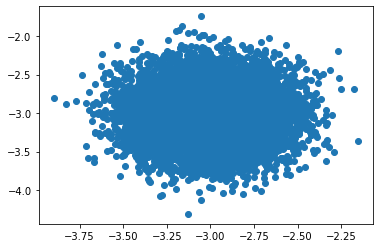

The likelihood of this dataset (in figure) under a mixture model is -1049225.991776101
The likelihood of this dataset (in figure) under a multivariate normal model is -602649.9138474719


In [4]:
dat = sample_mvn([-3, -3], cov1)
plt.scatter(dat[:,0],dat[:,1])
plt.show()
log_llh = compute_logdensity_gmm(dat, means, covars,  
               weights = [0.5,0.5])
print("The likelihood of this dataset (in figure) under a mixture model is", log_llh)
log_llh = compute_logdensity_mvn(dat, [-1, -1], cov1)
print("The likelihood of this dataset (in figure) under a multivariate normal model is", log_llh)


We see that the multivariate normal dataset is much more likely under the multivariate normal model than the mixture model.

$$ p(x) = \int p(x|\theta) p(\theta) d\theta $$

$$ p(x) = \mathbb E _{f(\theta)}  \left [ \frac { p(x|\theta) p(\theta)} { f(\theta)}  \right ] $$

If $f(\theta)=p(\theta)$ is the prior distribution, then the marginal likelihood is simply $$ p(x) = \mathbb E _{f(\theta)}  \left [ p(x|\theta)  \right ] $$

From Gelman (Bayesian data analysis): Recall that the conjugate distribution for the univariate normal with unknown mean and variance is the normal-inverse- $\chi^{2}$ distribution (3.6). We can use the inverse-Wishart distribution, a multivariate generalization of the scaled inverse- $\chi^{2}$, to describe the prior distribution of the matrix $\Sigma$. The conjugate prior distribution for $(\mu, \Sigma)$, the normal-inverseWishart, is conveniently parameterized in terms of hyperparameters $\left(\mu_{0}, \Lambda_{0} / \kappa_{0} ; \nu_{0}, \Lambda_{0}\right)$
$$
\begin{aligned}
\Sigma & \sim \text { Inv-Wishart }_{\nu_{0}}\left(\Lambda_{0}^{-1}\right) \\
\mu \mid \Sigma & \sim \mathrm{N}\left(\mu_{0}, \Sigma / \kappa_{0}\right)
\end{aligned}
$$
which corresponds to the joint prior density
$$
p(\mu, \Sigma) \propto|\Sigma|^{-\left(\left(\nu_{0}+d\right) / 2+1\right)} \exp \left(-\frac{1}{2} \operatorname{tr}\left(\Lambda_{0} \Sigma^{-1}\right)-\frac{\kappa_{0}}{2}\left(\mu-\mu_{0}\right)^{T} \Sigma^{-1}\left(\mu-\mu_{0}\right)\right)
$$

In [5]:
def prior_mvn_samples(nu_0, inv_lambda_0, mu_0, kappa_0, size=10):
    sigma_sample = invwishart.rvs(df=nu_0, scale = inv_lambda_0, size=size)
    mu_sample = [multivariate_normal.rvs(mean = mu_0, cov = sigma_sample[idx] / kappa_0) for idx in range(size)]
    return mu_sample, sigma_sample

def prior_gmm_samples(nu_s, inv_lambda_s, mu_s, kappa_s, size=10):
    nu_0, nu_1 = nu_s
    inv_lambda_0, inv_lambda_1 = inv_lambda_s
    mu_0, mu_1 = mu_s
    kappa_0, kappa_1 = kappa_s
    mu_sample0, sigma_sample0 = prior_mvn_samples(nu_0, inv_lambda_0, mu_0, kappa_0, size=size)
    mu_sample1, sigma_sample1 = prior_mvn_samples(nu_1, inv_lambda_1, mu_1, kappa_1, size=size)
    


In [6]:
def post_mvn(dat, nu_0, inv_lambda_0, mu_0, kappa_0):
    n = dat.shape[0]
    mu_0 = np.array(mu_0)
    y_mean = np.mean(dat, axis=0)
    mu_post = kappa_0/(kappa_0 + n) * mu_0 + n /(kappa_0 + n) * y_mean
    kappa_post = kappa_0 + n
    nu_post = nu_0 + n
    lambda_0 = np.linalg.inv(inv_lambda_0)
    lambda_post = lambda_0 + (dat - np.mean(dat, axis=0)).T.dot((dat - np.mean(dat, axis=0))) \
                + (kappa_0 * n)/(kappa_0 + n) * (np.mean(dat, axis=0) - mu_0).T.dot((np.mean(dat, axis=0) - mu_0))
    #inv_lambda_post = np.linalg.inv(lambda_post)
    print(lambda_0)
    print("(kappa_0 * n)/(kappa_0 + n)", (kappa_0 * n)/(kappa_0 + n))
    print((dat - np.mean(dat, axis=0)).T.dot((dat - np.mean(dat, axis=0))))
    print((kappa_0 * n)/(kappa_0 + n) * (np.mean(dat, axis=0) - mu_0).T.dot((np.mean(dat, axis=0) - mu_0)))
    print(mu_post, kappa_post, nu_post, lambda_post)
    return mu_post, kappa_post, nu_post, lambda_post

def logsumexp(x):
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))

def marginal_likelihood_mvn(dat, nu_0, inv_lambda_0, mu_0, kappa_0, size=1000):
    mu_sample0, sigma_sample0 = prior_mvn_samples(nu_0, inv_lambda_0, mu_0, kappa_0, size=size)
    mls = []
    for i in range(size):
        mean = mu_sample0[i]
        covar = sigma_sample0[i]
        ml = compute_logdensity_mvn(dat, mean, covar)
        mls.append(ml)
    mls = np.array(mls)
   
    return mls, np.exp(mls - logsumexp(mls))




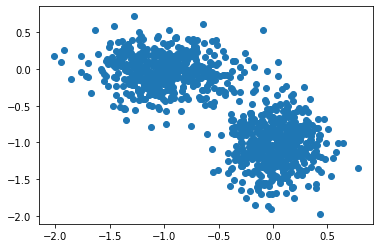

[[1. 0.]
 [0. 1.]]
(kappa_0 * n)/(kappa_0 + n) 9.900990099009901
[[ 339.70345117 -261.38945813]
 [-261.38945813  332.01447882]]
132.82539484112627
[-0.52292261 -0.54858837] 1010 1005 [[ 473.52884601 -128.56406329]
 [-128.56406329  465.83987366]]


-1862.279925325105

In [7]:
def marginal_likelihood_mvn_analytic(dat, nu_0, inv_lambda_0, mu_0, kappa_0):
    mu_post, kappa_post, nu_post, lambda_post = post_mvn(dat, nu_0, inv_lambda_0, mu_0, kappa_0)
    samp_cov = invwishart.rvs(df=nu_post, scale=lambda_post)
    samp_mean = multivariate_normal.rvs(mean = mu_post, cov = samp_cov / kappa_post)

    log_prior = invwishart.logpdf(samp_cov, df=nu_0, scale=inv_lambda_0) \
            + multivariate_normal.logpdf(samp_mean,mean=mu_0,cov = samp_cov / kappa_0)
    log_llh = compute_logdensity_mvn(dat, samp_mean, samp_cov)
    log_post = invwishart.logpdf(samp_cov, df=nu_post, scale=lambda_post) \
            + multivariate_normal.logpdf(samp_mean,mean=mu_post,cov = samp_cov / kappa_post)
    #print(np.linalg.inv(lambda_post))
    #print("log_prior", log_prior)
    #print("log_llh",log_llh)
    #print("log_post",log_post)
    return log_prior + log_llh - log_post
    
    
means = np.array([[0,-1], [-1,0]])
cov1 = np.diag([1,2])/20
cov2 = np.diag([2,1])/20
covars = [cov1, cov2]
dat = sample_gmm(means, covars)
plt.scatter(dat[:,0],dat[:,1])
plt.show()
marginal_likelihood_mvn_analytic(dat, 5, np.eye(2), [-3.1, -3.1], 10)

As hinted at by @Tim, the solution was quite simple. A function implementing the Metropolis-Hastings can take $\log (\pi(x))$ and $\log \left(q\left(x \mid x^{\text {old }}\right)\right)$, but then everything will have to happen on a log scale. Let $\alpha$ be the acceptance probability of the Metropolis-Hastings update and $x^{\prime}$ be the current value of the sampler. Then we
propose a new $x$ with acceptance probability of:
$$
\alpha\left(x \mid x^{\prime}\right)=\min \left(1, \frac{\pi(x) q\left(x^{\prime} \mid x\right)}{\pi\left(x^{\prime}\right) q\left(x \mid x^{\prime}\right)}\right)
$$
or in log terms
$$
\begin{array}{c}
\log \left(\alpha\left(x \mid x^{\prime}\right)\right)=\min \left(0, \log (\pi(x))+\log \left(q\left(x^{\prime} \mid x\right)\right)-\log \left(\pi\left(x^{\prime}\right)\right)-\log \right. \\
\left.\left(q\left(x \mid x^{\prime}\right)\right)\right)
\end{array}
$$
Then $\log (\alpha)$ can then be used to accept/reject the proposed $x$.
This is a useful interpretation of the Metropolis-hastings that has practical benefits. It is used in this textbook: http://mcmcinirt.stat.cmu.edu/archives/320
That is, an implementation of the Metropolis-Hastings that takes the log of the density to be sampled from, and the log of the proposal. Logs are convenient to use since they are not limited to the range of IEEE doubles, and they don't suffer from numerical over and underflow, as pointed out by @whuber.

Source: https://stats.stackexchange.com/questions/137710/metropolis-hastings-using-log-of-the-density

In [361]:
def metropolis_T_mvn(x, f, lamda, prior_hyperparams, scale = 1, n_steps=1):
    """
    Transition distribution: T(x'|x) using n-steps Metropolis sampler
    """
    if isinstance(scale, tuple):
        assert len(scale) == len(x)
        mu_scale, sig_df = scale
    nu_0, inv_lambda_0, mu_0, kappa_0 = prior_hyperparams
    for t in range(n_steps):
        # Proposal
        mu, sigma = x
        mu_prime = mu + mu_scale * np.random.randn() 
        sig_prime = invwishart.rvs(df=sig_df, scale=sig_df * sigma)
        
        # Compute logq (log transition prob) because the sigma proposal distribution is not symmetric
        # The mu proposal distribution is symmetric (normal distribution)
        logq_prime_cur = invwishart.logpdf(sig_prime, df=sig_df, scale=sig_df * sigma)
        logq_cur_prime = invwishart.logpdf(sigma, df=sig_df, scale=sig_df * sig_prime)
        
        # Compute log prior
        logprior_prime = invwishart.logpdf(sig_prime, df=nu_0, scale=inv_lambda_0) \
                        + multivariate_normal.logpdf(mu_prime, mean = mu_0, cov = sig_prime/kappa_0)
        logprior_cur = invwishart.logpdf(sigma, df=nu_0, scale=inv_lambda_0) \
                        + multivariate_normal.logpdf(mu, mean = mu_0, cov = sigma/kappa_0)
        
        # Acceptance prob
        log_a = logprior_prime + lamda * f((mu_prime, sig_prime)) \
                    + logq_cur_prime \
                - logprior_cur - lamda * f((mu, sigma)) - logq_prime_cur

        if np.log(np.random.rand()) < log_a:
            x = (mu_prime, sig_prime)
        #print("log_a, x", log_a, x)
        

    return x

def metropolis_ais_mvn(dat, nu_0, inv_lambda_0, mu_0, kappa_0, size=100, n_inter=1000, T = metropolis_T_mvn):
    mu_sample0, sigma_sample0 = prior_mvn_samples(nu_0, inv_lambda_0, mu_0, kappa_0, size=size)
    mu_sample0, sigma_sample0 = (np.array(mu_sample0), np.array(sigma_sample0))
    w = np.zeros(mu_sample0.shape[0])
    lambdas = np.linspace(0, 1, n_inter)
    diff = lambdas[1] - lambdas[0] 
    print(invwishart.rvs(df=nu_0, scale = inv_lambda_0, size=1))
    
    for idx, mu_samp, sig_samp in zip(range(size), mu_sample0, sigma_sample0):
        #print("sig_samp", sig_samp)
        for idlam, lamda in zip(range(n_inter), lambdas):
            #print(idlam, lamda)
            #print(idx, mu_samp)
            #_ = invwishart.rvs(df=20, scale=20*sig_samp)
            
            mu_samp, sig_samp = T((mu_samp, sig_samp), 
                                        lambda x:  compute_logdensity_mvn(dat, *x), lamda,
                                       scale = (1/5, 20),
                                       prior_hyperparams = (nu_0, inv_lambda_0, mu_0, kappa_0), 
                                 n_steps = 1)
            _llh = compute_logdensity_mvn(dat, mu_samp, sig_samp)
            w[idx] += diff * _llh
        print("w", w[idx], _llh, "sig_samp", sig_samp)
    return w
        
        
w = metropolis_ais_mvn(dat, 5, np.eye(2), [-3.1, -3.1], 10, size=100)

[[ 0.47221771 -0.1871023 ]
 [-0.1871023   0.23286386]]
w -1938.0207235964988 -1468.6934974143733 sig_samp [[ 0.48269736 -0.22163796]
 [-0.22163796  0.39033149]]
w -1985.6740214882932 -1471.993999184153 sig_samp [[ 0.42587948 -0.21854453]
 [-0.21854453  0.44489899]]
w -2163.0978973074284 -1490.5051578253067 sig_samp [[ 0.43362981 -0.1753159 ]
 [-0.1753159   0.39001476]]
w -2181.8461361340887 -1423.6355893545158 sig_samp [[ 0.40659224 -0.1889826 ]
 [-0.1889826   0.35442911]]
w -2263.3606749192977 -1493.4559713628682 sig_samp [[ 0.44420775 -0.18119147]
 [-0.18119147  0.39945459]]
w -2007.3425483590029 -1501.7376238125057 sig_samp [[ 0.37187955 -0.15888458]
 [-0.15888458  0.41910299]]
w -1930.7968677979563 -1521.5918632931796 sig_samp [[ 0.34828707 -0.13517038]
 [-0.13517038  0.41601413]]
w -2134.1400901383263 -1517.9743600988913 sig_samp [[ 0.38273575 -0.12379539]
 [-0.12379539  0.37597156]]
w -1944.1899855850731 -1501.6936366594796 sig_samp [[ 0.4232679  -0.20175617]
 [-0.20175617  0.425

w -1931.7068409530543 -1495.5119641907872 sig_samp [[ 0.45378753 -0.24205672]
 [-0.24205672  0.48876127]]
w -2139.2925252998684 -1556.6351957762386 sig_samp [[ 0.43414124 -0.17978517]
 [-0.17978517  0.43870229]]
w -1996.5838083051065 -1534.43175802909 sig_samp [[ 0.43044738 -0.23345192]
 [-0.23345192  0.50015759]]
w -2814.9483605644086 -1507.0663889348739 sig_samp [[ 0.36798971 -0.1685486 ]
 [-0.1685486   0.40850295]]
w -2127.798836725409 -1490.8684410754881 sig_samp [[ 0.42777853 -0.15861376]
 [-0.15861376  0.33422598]]
w -2410.867692063448 -1620.4017800854929 sig_samp [[ 0.44528923 -0.17683102]
 [-0.17683102  0.46067092]]
w -2015.776371154333 -1619.624389971879 sig_samp [[ 0.42887546 -0.17704251]
 [-0.17704251  0.42874041]]
w -2087.7090667439315 -1487.071618002922 sig_samp [[ 0.4434655  -0.19400045]
 [-0.19400045  0.40146334]]
w -2302.594123940079 -1613.928080107542 sig_samp [[ 0.57019733 -0.2844162 ]
 [-0.2844162   0.45328483]]
w -2002.4696115951006 -1502.3326446963686 sig_samp [[ 0

In [362]:
np.sort(w)

array([-2814.94836056, -2720.60213537, -2610.62178755, -2566.90304549,
       -2475.57624552, -2439.64742226, -2424.85875449, -2410.86769206,
       -2409.08574375, -2401.62757485, -2390.44547076, -2387.08849185,
       -2365.3795796 , -2322.3960765 , -2307.60250698, -2302.59412394,
       -2292.70589744, -2279.04494669, -2277.72178312, -2263.36067492,
       -2247.70810253, -2237.80739188, -2221.65034721, -2217.77786734,
       -2201.89867201, -2196.67336107, -2194.10360777, -2187.53052128,
       -2186.74560783, -2181.84613613, -2171.70264937, -2163.09789731,
       -2154.79168712, -2145.59439874, -2139.2925253 , -2134.14009014,
       -2129.94002129, -2127.79883673, -2120.08229813, -2110.88665203,
       -2109.21618497, -2106.21214818, -2101.27060939, -2093.16489028,
       -2087.70906674, -2084.39454197, -2079.21229908, -2066.18679068,
       -2056.56560883, -2056.05158743, -2055.99036965, -2049.22483369,
       -2048.11035278, -2033.24816204, -2033.19828674, -2028.48985377,
      

In [26]:
def compute_logdensity_gmm(dat, means, covars,  
               weights = [0.5,0.5]):
    comp0 = multivariate_normal(means[0], covars[0])
    comp1 = multivariate_normal(means[1], covars[1])
    llh = 0.0
    for x in (dat):
        w = [weights[idx] * (comp.pdf(x))
                 for idx, comp in enumerate([comp0, comp1])]
        sum_ = np.sum(w)
        l = np.log(sum_)
        llh += l
    return llh

def metropolis_T_gmm(x, f, lamda, prior_hyperparams, scale = 1, n_steps=1):
    """
    Transition distribution: T(x'|x) using n-steps Metropolis sampler
    """
    if isinstance(scale, tuple):
        mu_scale, sig_df = scale
    nu_0, inv_lambda_0, prior_mu_0, kappa_0, nu_1, inv_lambda_1, prior_mu_1, kappa_1 = prior_hyperparams
    for t in range(n_steps):
        # Proposal
        mu_samp0, sig_samp0, mu_samp1, sig_samp1 = x
        mu_prime0 = mu_samp0 + mu_scale * np.random.randn(*mu_samp0.shape) 
        mu_prime1 = mu_samp1 + mu_scale * np.random.randn(*mu_samp1.shape) 
        #sig_prime0 = invwishart.rvs(df=sig_df, scale=sig_df * sig_samp0)
        #sig_prime1 = invwishart.rvs(df=sig_df, scale=sig_df * sig_samp1)
        _L = np.linalg.cholesky(sig_samp0) + sig_df * np.random.randn(*sig_samp0.shape) 
        sig_prime0 = _L.dot(_L.T)
        _L = np.linalg.cholesky(sig_samp1) + sig_df * np.random.randn(*sig_samp1.shape) 
        sig_prime1 = _L.dot(_L.T)
        
        # Compute logq (log transition prob) because the sigma proposal distribution is not symmetric
        # The mu proposal distribution is symmetric (normal distribution)
        #logq_prime_cur = invwishart.logpdf(sig_prime0, df=sig_df, scale=sig_df * sig_samp0) \
        #                + invwishart.logpdf(sig_prime1, df=sig_df, scale=sig_df * sig_samp1) 
        #logq_cur_prime = invwishart.logpdf(sig_samp0, df=sig_df, scale=sig_df * sig_prime0) \
        #                + invwishart.logpdf(sig_samp1, df=sig_df, scale=sig_df * sig_prime1)
        logq_prime_cur = 0
        logq_cur_prime = 0
        # Compute log prior
        logprior_prime = invwishart.logpdf(sig_prime0, df=nu_0, scale=inv_lambda_0) \
                        + multivariate_normal.logpdf(mu_prime0, mean = prior_mu_0, cov = sig_prime0/kappa_0) \
                        + invwishart.logpdf(sig_prime1, df=nu_1, scale=inv_lambda_1) \
                        + multivariate_normal.logpdf(mu_prime1, mean = prior_mu_1, cov = sig_prime1/kappa_1)
        logprior_cur = invwishart.logpdf(sig_samp0, df=nu_0, scale=inv_lambda_0) \
                        + multivariate_normal.logpdf(mu_samp0, mean = prior_mu_0, cov = sig_samp0/kappa_0) \
                        + invwishart.logpdf(sig_samp1, df=nu_1, scale=inv_lambda_1) \
                        + multivariate_normal.logpdf(mu_samp1, mean = prior_mu_1, cov = sig_samp1/kappa_1)
        
        # Acceptance prob
        log_a = logprior_prime + lamda * f(dat, [mu_prime0, mu_prime1], \
                                               [sig_prime0, sig_prime1]) \
                    + logq_cur_prime \
                - logprior_cur - lamda * f(dat, [mu_samp0, mu_samp1], \
                                               [sig_samp0, sig_samp1]) - logq_prime_cur

        if np.log(np.random.rand()) < log_a:
            x = (mu_prime0, sig_prime0, mu_prime1, sig_prime1)
    #print("log_a, x", log_a, x)
        

    return x

def metropolis_ais_gmm(dat, nu_0, inv_lambda_0, mu_0, kappa_0, 
                   nu_1, inv_lambda_1, mu_1, kappa_1,
                   size=100, n_inter=1000, T = metropolis_T_gmm, 
                      chain = None):
    mu_sample0, sigma_sample0 = prior_mvn_samples(nu_0, inv_lambda_0, mu_0, kappa_0, size=size)
    mu_sample0, sigma_sample0 = (np.array(mu_sample0), np.array(sigma_sample0))
    
    mu_sample1, sigma_sample1 = prior_mvn_samples(nu_1, inv_lambda_1, mu_1, kappa_1, size=size)
    mu_sample1, sigma_sample1 = (np.array(mu_sample1), np.array(sigma_sample1))
    
    ws = []
    lambdas = np.linspace(0, 1, n_inter)
    diff = lambdas[1] - lambdas[0] 
    
    for idx, mu_samp0, sig_samp0, mu_samp1, sig_samp1 in zip(range(size), mu_sample0, \
                                                             sigma_sample0, mu_sample1, sigma_sample1):
        w = 0
        print("samps", mu_samp0, sig_samp0, mu_samp1, sig_samp1)
        for idlam, lamda in zip(range(n_inter), lambdas):
            #print(idlam, lamda)
            #print(idx, mu_samp)
            #_ = invwishart.rvs(df=20, scale=20*sig_samp)
            
            mu_samp0, sig_samp0, mu_samp1, sig_samp1 = T((mu_samp0, sig_samp0, mu_samp1, sig_samp1), 
                                      compute_logdensity_gmm, lamda,
                                       scale = (1/100, 1/100),
                                       prior_hyperparams = (nu_0, inv_lambda_0, mu_0, kappa_0, \
                                                           nu_1, inv_lambda_1, mu_1, kappa_1
                                                           ), 
                                 n_steps = 10)
            _llh = compute_logdensity_gmm(dat, [mu_samp0, mu_samp1], [sig_samp0, sig_samp1])
            w += diff * _llh
            print("w", w, _llh)
        
        ws.append(w)
        with open('weights_chain{chain}.pkl', 'wb') as f:
            pickle.dump(ws, f)
            
    return ws
        
means = np.array([[0,-1], [-1,0]])
cov1 = np.diag([1,2])/20
cov2 = np.diag([2,1])/20
covars = [cov1, cov2]
dat = sample_gmm(means, covars)

ws = metropolis_ais_gmm(dat, 5, np.eye(2), [0, -2], 10,
                   5, np.eye(2), [0, -2.1], 10,
                   size=100, n_inter=100, chain = 11)

samps [-0.31394978 -1.74493593] [[0.91822684 0.17191562]
 [0.17191562 0.56126917]] [ 0.08693596 -2.12446156] [[0.22539423 0.10466214]
 [0.10466214 0.32867393]]
w -39.10934882567896 -3871.8255337422165
w -76.24514504864268 -3676.4438260734078
w -111.64095120420704 -3504.184809400871
w -145.98612552673433 -3400.1722579302004
w -179.1312706772502 -3281.369369901073
w -211.50216166616872 -3204.7182079029344
w -243.179525174537 -3136.05898732846
w -274.0488504837053 -3056.0632056076615
w -304.17552084349956 -2982.540365619634
w -333.7299852859139 -2925.8919797990206
w -363.3179018385626 -2929.2037387122173
w -392.1668791596932 -2856.0487547919315
w -420.0743883432625 -2762.8434091733616
w -447.84243090148493 -2749.0362132640207
w -475.084545333985 -2696.9693288175017
w -501.81393286251864 -2646.209365324835
w -528.0422482945121 -2596.6032277673467
w -554.2821528775082 -2597.750553716616
w -580.208189486735 -2566.677624313458
w -606.0887194206297 -2562.172463455566
w -631.8326337369716 -2548

KeyboardInterrupt: 

In [41]:
w = []
for i in range(10):
    try:
        with open(f"marginal/gmmweights_chain{i}_cholesky.pkl", 'rb') as f:
            w.append(pickle.load(f))
    except:
        pass

In [43]:
np.sort(np.concatenate(w))

array([-2240.84110666, -1961.15115547, -1896.26447259, -1889.76943475,
       -1886.36815517, -1882.81537305, -1880.82829038, -1871.26504045,
       -1846.92482893, -1833.36923895, -1826.48844882, -1826.02437088,
       -1822.17713829, -1817.26374504, -1814.2080009 , -1814.16842707,
       -1810.38007938, -1801.66097602, -1796.67225692, -1787.56314164,
       -1785.10633239, -1775.25675139, -1772.83157263, -1772.55789121,
       -1766.64274276, -1762.75891615, -1762.01317407, -1757.65608497,
       -1755.32674574, -1753.84404531, -1751.10944617, -1748.33505413,
       -1748.25444862, -1747.74012062, -1746.34017665, -1742.90387688,
       -1742.5135624 , -1740.36528302, -1739.64686472, -1739.49713501,
       -1737.34153272, -1733.90315371, -1733.31585209, -1730.05650501,
       -1728.33350336, -1725.93581316, -1724.73364887, -1724.6925314 ,
       -1724.53489543, -1722.62037153, -1719.72689789, -1719.18401934,
       -1717.0206712 , -1709.79508101, -1705.31827124, -1701.03791607,
      

In [3]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt


In [3]:
import inspect


In [5]:
print(inspect.getsourcefile(pm.sample_smc))

/Users/alng/miniconda3/envs/leabra/lib/python3.7/site-packages/pymc3/smc/sample_smc.py


(-25.0, 25.0)

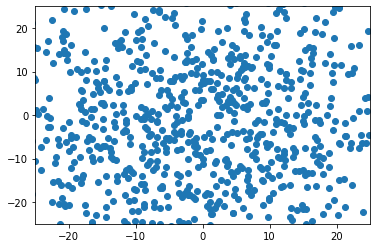

In [6]:
plt.scatter(dat[:,0],dat[:,1])
plt.xlim(-25,25)
plt.ylim(-25,25)

$$
\begin{aligned}
\text{covariance matrix} \sim Exponential()
\\
\text{mean} \sim N([0,-2])\\
\text{dat} \sim N(mean, \text{covariance matrix})
\end{aligned}
$$

p(mean|dat)


p(covariance|dat)

$$
\begin{aligned}
\text{covariance matrix}_1 \sim Exponential()
\\
\text{mean}_1 \sim N([0,-2])\\
\text{covariance matrix}_2 \sim Exponential()
\\
\text{mean}_2 \sim N([-2,0])\\
\text{dat} \sim 0.5 N(mean_1, \text{covariance matrix}_1) + 0.5 N(mean_2, \text{covariance matrix}_2)
\end{aligned}
$$

In [18]:
??tt.repeat

In [27]:
def fit_mvn_model(dat):
    p = 0.5
    nu_0, inv_lambda_0, mu_0, kappa_0 = (5, np.eye(2), np.array([-2, -2]), 1)
    model = pm.Model()
    with model:
        #comp = pm.Bernoulli("comp", p)

        sd_dim1 = pm.Exponential('sd1', 0.25, shape=1)
        sd_dim2 = pm.Exponential('sd2', 0.25, shape=1)
        mean = pm.MvNormal('mean', mu = mu_0,  cov=np.eye(2), shape=2)
        vals = pm.MvNormal('vals', mu=mean, chol = tt.diag(tt.concatenate([sd_dim1,sd_dim2])), observed=dat)

        trace = pm.sample(10000, cores=4, chains=4, progressbar=False)
    return trace, model

def fit_gmm_model(dat):
    model = pm.Model()
    k = 2
    ndata = dat.shape[0]
    nu_0, inv_lambda_0, mu_0, kappa_0 = (5, np.eye(2), np.array([0, -3.5]), 1)
    nu_1, inv_lambda_1, mu_1, kappa_1 = (5, np.eye(2), np.array([-3.5, 0]), 1)
    with model:
        # cluster centers
        meandim1 = pm.Normal("meandim1", mu=0, sigma=np.array([1]))
        meandim2 = pm.Normal("meandim2", mu=-3.5, sigma=np.array([1]))

        # measurement error
        sd_dim1 = pm.Exponential('sd1', 0.25, shape=1)
        sd_dim2 = pm.Exponential('sd2', 0.25, shape=1)

        comp1 = pm.MvNormal.dist( mu = [meandim1, meandim2], chol = tt.diag(tt.concatenate([sd_dim1,sd_dim2])))
        comp2 = pm.MvNormal.dist( mu = [meandim2, meandim1], chol = tt.diag(tt.concatenate([sd_dim2,sd_dim1])))

        # latent cluster of each observation
        #category = pm.Categorical("category", p=p, shape=ndata)

        # likelihood for each observed value
        #points = pm.Normal("obs", mu=means[category], sigma=sd, observed=dat)
        likelihood = pm.Mixture(name = "lh", w = [0.5, 0.5], comp_dists = [comp1,comp2], observed=dat)

        # trace = pm.sample_smc(5000, parallel=False)
        trace = pm.sample(draws=10000, cores=1, chains=4, progressbar=False)
    return trace, model



In [28]:
from pymc3.model import modelcontext
from scipy import dot
import scipy.stats as st
from scipy.linalg import cholesky as chol
import warnings
import arviz as az

def Marginal_llk(mtrace, model=None, logp=None, maxiter=1000):
    """The Bridge Sampling Estimator of the Marginal Likelihood.

    Parameters
    ----------
    mtrace : MultiTrace, result of MCMC run
    model : PyMC Model
        Optional model. Default None, taken from context.
    logp : Model Log-probability function, read from the model by default
    maxiter : Maximum number of iterations

    Returns
    -------
    marg_llk : Estimated Marginal log-Likelihood.
    """
    r0, tol1, tol2 = 0.5, 1e-10, 1e-4

    model = modelcontext(model)
    if logp is None:
        logp = model.logp_array
    vars = model.free_RVs
    print("vars", vars)
    # Split the samples into two parts  
    # Use the first 50% for fiting the proposal distribution and the second 50% 
    # in the iterative scheme.
    len_trace = len(mtrace)
    nchain = mtrace.nchains
    
    N1_ = len_trace // 2
    N1 = N1_*nchain
    N2 = len_trace*nchain - N1

    neff_list = dict() # effective sample size

    arraysz = model.bijection.ordering.size
    samples_4_fit = np.zeros((arraysz, N1))
    samples_4_iter = np.zeros((arraysz, N2))
    # matrix with already transformed samples
    for var in vars:
        varmap = model.bijection.ordering.by_name[var.name]
        # for fitting the proposal
        x = mtrace[:N1_][var.name]
        samples_4_fit[varmap.slc, :] = x.reshape((x.shape[0], 
                                                  np.prod(x.shape[1:], dtype=int))).T
        # for the iterative scheme
        x2 = mtrace[N1_:][var.name]
        samples_4_iter[varmap.slc, :] = x2.reshape((x2.shape[0], 
                                                    np.prod(x2.shape[1:], dtype=int))).T
        # effective sample size of samples_4_iter, scalar
        


    # median effective sample size (scalar)
    esses = az.stats.ess(mtrace[N1_:], method='median')
    neff = np.median(np.array(esses.to_array()).ravel()) #pm.stats.dict2pd(neff_list,'temp').median()
    # get mean & covariance matrix and generate samples from proposal
    m = np.mean(samples_4_fit, axis=1)
    V = np.cov(samples_4_fit)
    L = chol(V, lower=True)

    # Draw N2 samples from the proposal distribution
    gen_samples = m[:, None] + dot(L, st.norm.rvs(0, 1, 
                                         size=samples_4_iter.shape))

    # Evaluate proposal distribution for posterior & generated samples
    q12 = st.multivariate_normal.logpdf(samples_4_iter.T, m, V)
    q22 = st.multivariate_normal.logpdf(gen_samples.T, m, V)

    # Evaluate unnormalized posterior for posterior & generated samples
    q11 = np.asarray([logp(point) for point in samples_4_iter.T])
    q21 = np.asarray([logp(point) for point in gen_samples.T])

    # Iterative scheme as proposed in Meng and Wong (1996) to estimate
    # the marginal likelihood
    def iterative_scheme(q11, q12, q21, q22, r0, neff, tol, maxiter, criterion):
        l1 = q11 - q12
        l2 = q21 - q22
        lstar = np.median(l1) # To increase numerical stability, 
                              # subtracting the median of l1 from l1 & l2 later
        s1 = neff/(neff + N2)
        s2 = N2/(neff + N2)
        r = r0
        r_vals = [r]
        logml = np.log(r) + lstar
        criterion_val = 1 + tol

        i = 0
        while (i <= maxiter) & (criterion_val > tol):
            rold = r
            logmlold = logml
            numi = np.exp(l2 - lstar)/(s1 * np.exp(l2 - lstar) + s2 * r)
            deni = 1/(s1 * np.exp(l1 - lstar) + s2 * r)
            if np.sum(~np.isfinite(numi))+np.sum(~np.isfinite(deni)) > 0:
                warnings.warn("""Infinite value in iterative scheme, returning NaN. 
                Try rerunning with more samples.""")
            r = (N1/N2) * np.sum(numi)/np.sum(deni)
            r_vals.append(r)
            logml = np.log(r) + lstar
            i += 1
            if criterion=='r':
                criterion_val = np.abs((r - rold)/r)
            elif criterion=='logml':
                criterion_val = np.abs((logml - logmlold)/logml)

        if i >= maxiter:
            return dict(logml = np.NaN, niter = i, r_vals = np.asarray(r_vals))
        else:
            return dict(logml = logml, niter = i)

    # Run iterative scheme:
    tmp = iterative_scheme(q11, q12, q21, q22, r0, neff, tol1, maxiter, 'r')
    if ~np.isfinite(tmp['logml']):
        warnings.warn("""logml could not be estimated within maxiter, rerunning with 
                      adjusted starting value. Estimate might be more variable than usual.""")
        # use geometric mean as starting value
        r0_2 = np.sqrt(tmp['r_vals'][-2]*tmp['r_vals'][-1])
        tmp = iterative_scheme(q11, q12, q21, q22, r0_2, neff, tol2, maxiter, 'logml')

    return dict(logml = tmp['logml'], niter = tmp['niter'], method = "normal", 
                q11 = q11, q12 = q12, q21 = q21, q22 = q22)

sds = list(range(1, 20))
sds.insert(0,0.1)
mvn_traces_new = np.zeros((len(sds),len(sds)))
gmm_traces_new = np.zeros((len(sds),len(sds)))
#mvn_traces_new[:19, :19] = mvn_traces
#gmm_traces_new[:19, :19] = gmm_traces
for idx, sd1 in enumerate(sds):
    for idy, sd2 in enumerate(sds):
#         if not (sd1 == 19 and sd2 == 19):
#             continue
        print("sd1", sd1, "sd2", sd2)
        means = np.array([[-3.5,0], [0,-3.5]])
        cov1 = np.diag([sd1**2,sd2**2])
        cov2 = np.diag([sd2**2,sd1**2])
        covars = [cov1, cov2]
        dat = sample_gmm(means, covars,n_samples=10000)
        mvn_trace, mvn_model = fit_mvn_model(dat)
        mvn_dic = Marginal_llk(mvn_trace, model=mvn_model)
        mvn_traces_new[idx, idy] = mvn_dic["logml"]
        print("MVN", mvn_dic["logml"])
        gmm_trace, gmm_model = fit_gmm_model(dat)
        gmm_dic = Marginal_llk(gmm_trace, model=gmm_model)
        gmm_traces_new[idx, idy] = gmm_dic["logml"]
        print("GMM", gmm_dic["logml"])

sd1 0.1 sd2 0.1


/Users/alng/miniconda3/envs/leabra/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, sd2, sd1]


KeyboardInterrupt: 

In [12]:
dic

{'logml': -8730.711135104611,
 'niter': 4,
 'method': 'normal',
 'q11': array([-8729.88602223, -8729.49468507, -8729.43957619, ...,
        -8728.60926791, -8728.27785595, -8729.49328454]),
 'q12': array([0.87181572, 1.28837301, 1.34530161, ..., 2.00960986, 2.53613953,
        1.19411487]),
 'q21': array([-8729.39781821, -8728.89581177, -8728.8195799 , ...,
        -8730.84934194, -8728.33986573, -8728.94459119]),
 'q22': array([1.55547248, 1.73412401, 1.64043058, ..., 0.45823329, 2.51634438,
        1.60082338])}

In [73]:
dat

<xarray.Dataset>
Dimensions:    (sd1_dim_0: 1, sd2_dim_0: 1)
Coordinates:
  * sd1_dim_0  (sd1_dim_0) int64 0
  * sd2_dim_0  (sd2_dim_0) int64 0
Data variables:
    meandim1   float64 7.048e+03
    meandim2   float64 7.269e+03
    sd1        (sd1_dim_0) float64 6.17e+03
    sd2        (sd2_dim_0) float64 6.362e+03

6705.148413677569

In [90]:
np.save("gmm_traces_new", gmm_traces_new)

In [ ]:
np.save("mvn_traces_new", mvn_traces_new)

<Figure size 720x720 with 0 Axes>

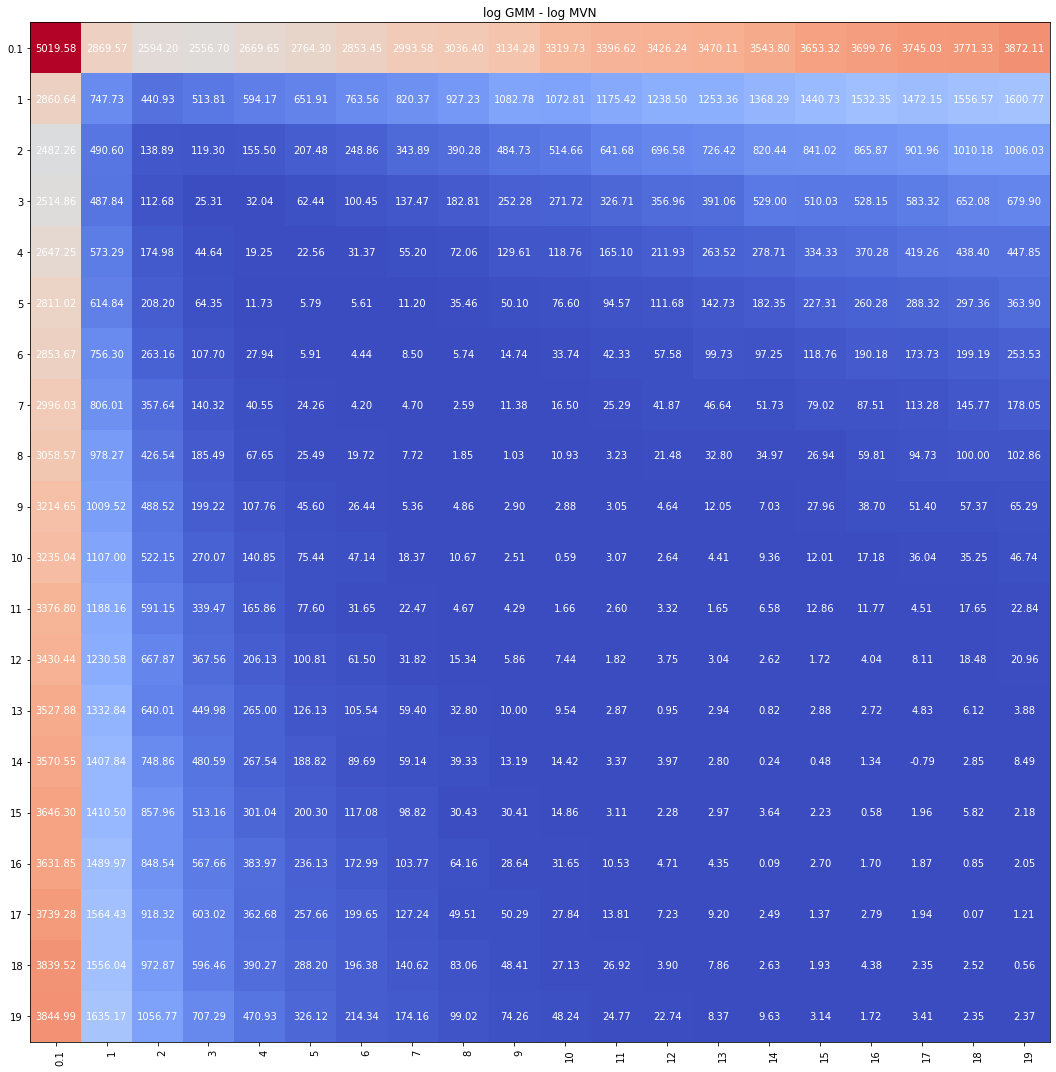

In [23]:
plt.figure(figsize=(10,10))
dat = gmm_traces_new-mvn_traces_new
fig, ax = plt.subplots(figsize = (15,15))
im = ax.imshow(dat, cmap='coolwarm')

# We want to show all ticks...
ax.set_xticks(np.arange(dat.shape[0]))
ax.set_yticks(np.arange(dat.shape[1]))
# ... and label them with the respective list entries
ax.set_xticklabels(sds[:20])
ax.set_yticklabels(sds[:20])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(dat.shape[0]):
    for j in range(dat.shape[1]):
        text = ax.text(j, i, "%.2f" %(dat[i, j]),
                       ha="center", va="center", color="w")
import matplotlib.lines as mlines
# l = mlines.Line2D([0,len(get_tensor_names)], [0,len(get_tensor_names)])
# ax.add_line(l)
ax.set_title("log GMM - log MVN")
fig.tight_layout()
plt.show()

In [9]:
import pickle
import numpy as np
sds = list(range(1, 20))
sds.insert(0,0.1)
print(sds)
mvn_traces_new = np.zeros((len(sds),len(sds)))
gmm_traces_new = np.zeros((len(sds),len(sds)))
for idx, sd1 in enumerate(sds):
    for idy, sd2 in enumerate(sds):
        with open(f'results/gmm_sd1_{sd1}_sd2_{sd2}', 'rb') as handle:
            dat = pickle.load(handle)
            gmm_traces_new[idx,idy] = dat['logml']
        with open(f'results/mvn_sd1_{sd1}_sd2_{sd2}', 'rb') as handle:
            dat = pickle.load(handle)
            mvn_traces_new[idx,idy] = dat['logml']
            

[0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


<Figure size 720x720 with 0 Axes>

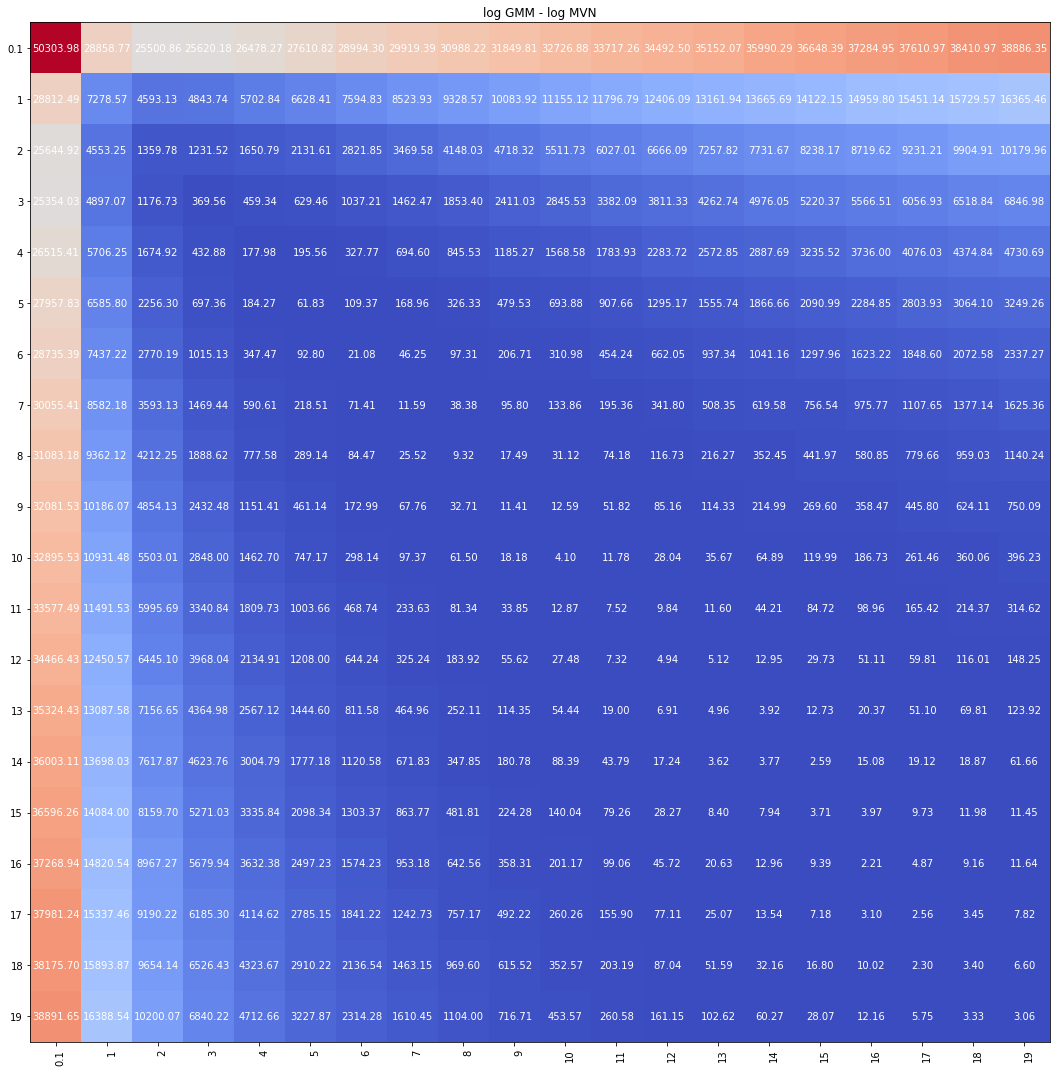

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
dat = gmm_traces_new-mvn_traces_new
fig, ax = plt.subplots(figsize = (15,15))
im = ax.imshow(dat, cmap='coolwarm')

# We want to show all ticks...
ax.set_xticks(np.arange(dat.shape[0]))
ax.set_yticks(np.arange(dat.shape[1]))
# ... and label them with the respective list entries
ax.set_xticklabels(sds[:20])
ax.set_yticklabels(sds[:20])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(dat.shape[0]):
    for j in range(dat.shape[1]):
        text = ax.text(j, i, "%.2f" %(dat[i, j]),
                       ha="center", va="center", color="w")
import matplotlib.lines as mlines
# l = mlines.Line2D([0,len(get_tensor_names)], [0,len(get_tensor_names)])
# ax.add_line(l)
ax.set_title("log GMM - log MVN")
fig.tight_layout()
plt.show()

/Users/alng/miniconda3/envs/leabra/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'meandim1'}>,
        <AxesSubplot:title={'center':'meandim1'}>],
       [<AxesSubplot:title={'center':'meandim2'}>,
        <AxesSubplot:title={'center':'meandim2'}>],
       [<AxesSubplot:title={'center':'sd1'}>,
        <AxesSubplot:title={'center':'sd1'}>],
       [<AxesSubplot:title={'center':'sd2'}>,
        <AxesSubplot:title={'center':'sd2'}>]], dtype=object)

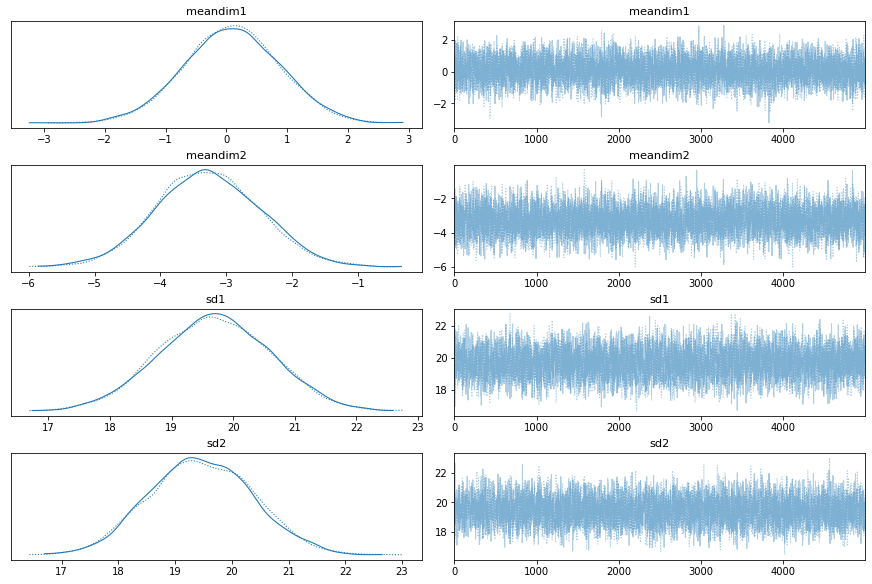

In [12]:
import arviz as az
az.plot_trace(gmm_trace)

In [40]:
trace.report.log_marginal_likelihood

array([-8709.98241345, -8710.10702141, -8710.00278039, -8710.08939766])

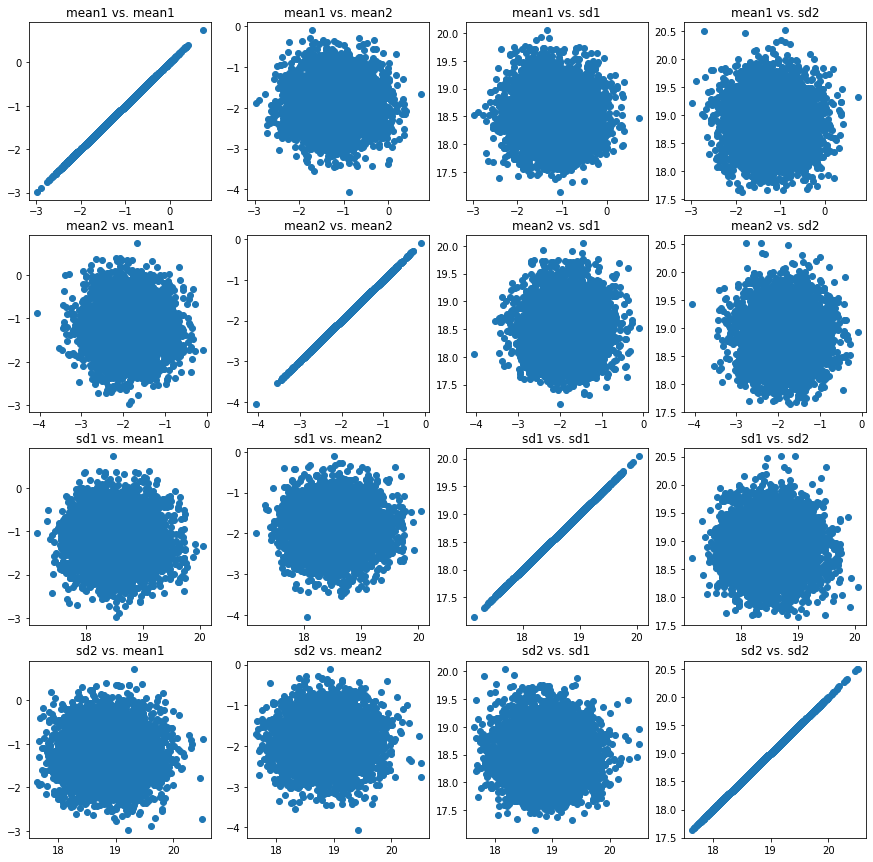

In [44]:
def corr_plots(trace):
    meandim1 = [trace[i]["mean"][0] for i in range(len(trace))]
    meandim2 = [trace[i]["mean"][1] for i in range(len(trace))]
    sd1 = [trace[i]["sd1"] for i in range(len(trace))]
    sd2 = [trace[i]["sd2"] for i in range(len(trace))]
    fig, ax = plt.subplots(4, 4, figsize=(15,15))
    params = [meandim1, meandim2, sd1, sd2]
    param_names = ["mean1", "mean2", "sd1", "sd2"]
    for i in range(4):
        for j in range(4):
            ax[i][j].scatter(params[i], params[j])
            ax[i][j].set_title(f"{param_names[i]} vs. {param_names[j]}")
    plt.show()
corr_plots(trace)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.001
Stage:   3 Beta: 0.002
Stage:   4 Beta: 0.007
Stage:   5 Beta: 0.025
Stage:   6 Beta: 0.095
Stage:   7 Beta: 0.339
Stage:   8 Beta: 0.944
Stage:   9 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.001
Stage:   3 Beta: 0.002
Stage:   4 Beta: 0.007
Stage:   5 Beta: 0.025
Stage:   6 Beta: 0.094
Stage:   7 Beta: 0.338
Stage:   8 Beta: 0.949
Stage:   9 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.001
Stage:   3 Beta: 0.002
Stage:   4 Beta: 0.007
Stage:   5 Beta: 0.024
Stage:   6 Beta: 0.089
Stage:   7 Beta: 0.325
Stage:   8 Beta: 0.905
Stage:   9 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.001
Stage:   3 Beta: 0.002
Stage:   4 Beta: 0.007
Stage:   5 Beta: 0.024
Stage:   6 Beta: 0.089
Stage:   7 Beta: 0.325
Stage:   8 Beta: 0.920
Stage:   9 Beta: 1.000


/Users/alng/miniconda3/envs/leabra/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'meandim1'}>,
        <AxesSubplot:title={'center':'meandim1'}>],
       [<AxesSubplot:title={'center':'meandim2'}>,
        <AxesSubplot:title={'center':'meandim2'}>],
       [<AxesSubplot:title={'center':'sd1'}>,
        <AxesSubplot:title={'center':'sd1'}>],
       [<AxesSubplot:title={'center':'sd2'}>,
        <AxesSubplot:title={'center':'sd2'}>]], dtype=object)

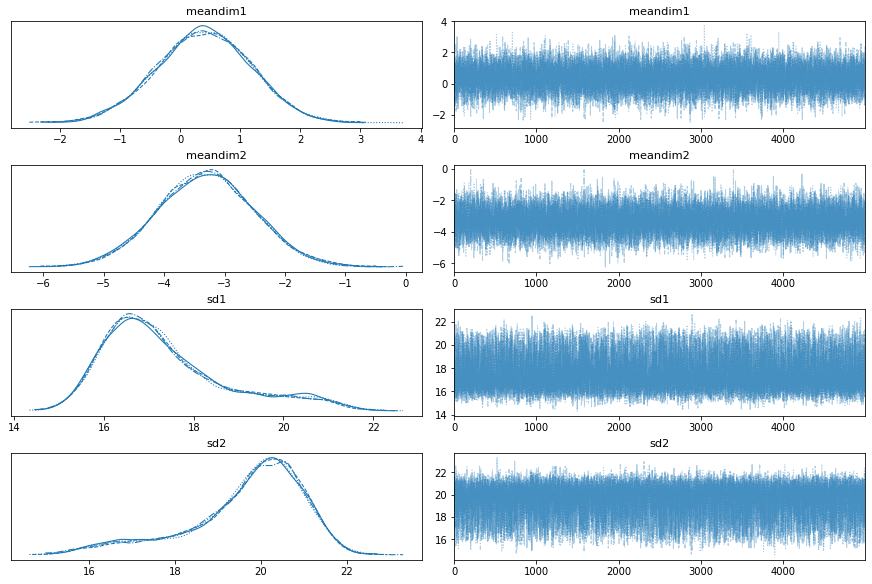

In [46]:
az.plot_trace(trace)

In [49]:
trace.report.log_marginal_likelihood

array([-8706.43614141, -8706.50022004, -8706.47312638, -8706.44289807])

In [84]:
trace[0]

{'meandim1': 0.7190679464762844,
 'meandim2': -2.9687136764874418,
 'sd_log__': array([2.33427271]),
 'sd': array([10.32195016])}

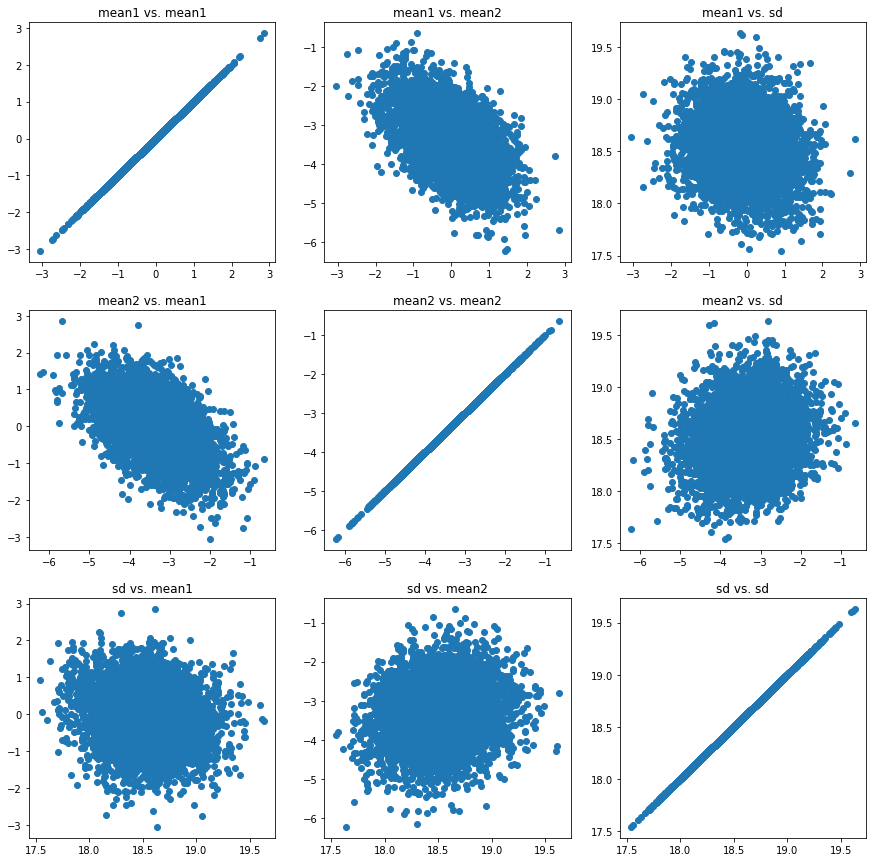

In [68]:
def corr_plots(trace):
    meandim1 = [trace[i]["meandim1"] for i in range(len(trace))]
    meandim2 = [trace[i]["meandim2"] for i in range(len(trace))]
    sd0 = [trace[i]["sd"] for i in range(len(trace))]
    fig, ax = plt.subplots(3, 3, figsize=(15,15))
    params = [meandim1, meandim2, sd0]
    param_names = ["mean1", "mean2", "sd"]
    for i in range(3):
        for j in range(3):
            ax[i][j].scatter(params[i], params[j])
            ax[i][j].set_title(f"{param_names[i]} vs. {param_names[j]}")
    plt.show()
corr_plots(trace)

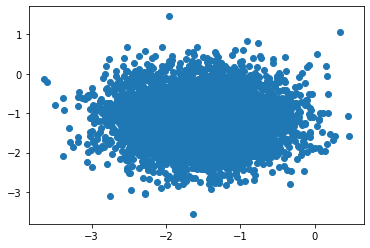

In [31]:

x, y = zip(*[trace[i]["mean"] for i in range(len(trace))])
plt.scatter(x, y)

In [62]:
trace[0]

{'chol_cov_cholesky-cov-packed__': array([2.96429208, 1.54619343, 2.92447645]),
 'mean': array([-0.64760977, -2.99805404]),
 'chol_cov': array([19.38097823,  1.54619343, 18.6244726 ]),
 'chol_cov_stds': array([19.38097823, 18.68854445]),
 'chol_cov_corr': array([[1.        , 0.08273482],
        [0.08273482, 1.        ]])}

In [ ]:

p = 0.5
nu_0, inv_lambda_0, mu_0, kappa_0 = (5, np.eye(2), np.array([0, -2]), 10)

with pm.Model() as model:
    #comp = pm.Bernoulli("comp", p)

    sd_dist = pm.Exponential.dist(1.0, shape=2)
    chol, corr, stds = pm.LKJCholeskyCov('chol_cov', n=2, eta=2,
            sd_dist=sd_dist, compute_corr=True)
    mean = pm.MvNormal('mean', mu = mu_0,  chol=chol / np.sqrt(kappa_0), shape=2)
    vals = pm.MvNormal('vals', mu=mean, chol = chol, observed=dat)
    
    trace = pm.sample_smc(1000, random_seed=42, parallel=True)

$$
\begin{aligned}
\text{covariance matrix}_1 \sim Exponential()
\\
\text{mean}_1 \sim N([0,-2])\\
\text{covariance matrix}_2 \sim Exponential()
\\
\text{mean}_2 \sim N([-2,0])\\
\text{dat} \sim 0.5 N(mean_1, \text{covariance matrix}_1) + 0.5 N(mean_2, \text{covariance matrix}_2)
\end{aligned}
$$

In [ ]:

p = 0.5
nu_0, inv_lambda_0, mu_0, kappa_0 = (5, np.eye(2), np.array([0, -2]), 1)

with pm.Model() as model:
    #comp = pm.Bernoulli("comp", p)

    sd_dist = pm.Exponential.dist(0.25, shape=2)
    chol, corr, stds = pm.LKJCholeskyCov('chol_cov', n=2, eta=100,
            sd_dist=sd_dist, compute_corr=True)
    mean = pm.MvNormal('mean', mu = mu_0,  chol=chol / np.sqrt(kappa_0), shape=2)
    vals = pm.MvNormal('vals', mu=mean, chol = chol, observed=dat)
    
    trace = pm.sample_smc(5000, random_seed=42, parallel=True)

In [13]:
model = pm.Model()
k = 2
ndata = dat.shape[0]
nu_0, inv_lambda_0, mu_0, kappa_0 = (5, np.eye(2), np.array([0, -3.5]), 10000)
nu_1, inv_lambda_1, mu_1, kappa_1 = (5, np.eye(2), np.array([-3.5, 0]), 10000)
with model:
    # cluster sizes
    #p = pm.Dirichlet("p", a=np.array([1.0, 1.0]), shape=k)
    # ensure all clusters have some points
    #p_min_potential = pm.Potential("p_min_potential", tt.switch(tt.min(p) < 0.1, -np.inf, 0))

    # cluster centers
    
    #means 
    #break symmetry
#     order_means_potential = pm.Potential(
#         "order_means_potential",
#         tt.switch(means[1] - means[0] < 0, -np.inf, 0)
#     )

    # measurement error
    sd_dist1 = pm.Exponential.dist(0.25, shape=2)
    sd_dist2 = pm.Exponential.dist(0.25, shape=2)
    chol1, corr1, stds1 = pm.LKJCholeskyCov('chol_cov_1', n=2, eta=100,
            sd_dist=sd_dist1, compute_corr=True)
    chol2, corr2, stds2 = pm.LKJCholeskyCov('chol_cov_2', n=2, eta=100,
            sd_dist=sd_dist2, compute_corr=True)
    means_1 = pm.MvNormal("means_comp_1", mu=mu_0, cov=inv_lambda_0/kappa_0, shape=2)
    means_2 = pm.MvNormal("means_comp_2", mu=mu_1, cov= inv_lambda_0 /kappa_0 , shape=2)
    
    comp1 = pm.MvNormal.dist(mu = means_1, chol=chol1)
    comp2 = pm.MvNormal.dist(mu=means_2, chol = chol2)

    # latent cluster of each observation
    #category = pm.Categorical("category", p=p, shape=ndata)

    # likelihood for each observed value
    #points = pm.Normal("obs", mu=means[category], sigma=sd, observed=dat)
    likelihood = pm.Mixture(name = "lh", w = [0.5, 0.5], comp_dists = [comp1,comp2], observed=dat)
    
    trace = pm.sample_smc(3000, random_seed=1, parallel=False)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.001
Stage:   3 Beta: 0.003
Stage:   4 Beta: 0.004
Stage:   5 Beta: 0.005
Stage:   6 Beta: 0.006
Stage:   7 Beta: 0.007
Stage:   8 Beta: 0.009
Stage:   9 Beta: 0.011
Stage:  10 Beta: 0.014
Stage:  11 Beta: 0.018
Stage:  12 Beta: 0.025
Stage:  13 Beta: 0.037
Stage:  14 Beta: 0.059
Stage:  15 Beta: 0.107
Stage:  16 Beta: 0.190
Stage:  17 Beta: 0.262
Stage:  18 Beta: 0.319
Stage:  19 Beta: 0.379
Stage:  20 Beta: 0.445
Stage:  21 Beta: 0.510
Stage:  22 Beta: 0.577
Stage:  23 Beta: 0.646
Stage:  24 Beta: 0.717
Stage:  25 Beta: 0.800
Stage:  26 Beta: 0.996
Stage:  27 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.001
Stage:   3 Beta: 0.003
Stage:   4 Beta: 0.004
Stage:   5 Beta: 0.005
Stage:   6 Beta: 0.006
Stage:   7 Beta: 0.007
Stage:   8 Beta: 0.009
Stage:   9 Beta: 0.010
Stage:  10 Beta: 0.013
Stage:  11 Beta: 0.016
Stage:  12 Beta: 0.025
S

In [16]:
trace[0]

{'chol_cov_1_cholesky-cov-packed__': array([ 1.15576113, 47.68861452, -8.26558027]),
 'chol_cov_2_cholesky-cov-packed__': array([ 2.94552837, -0.87190826,  2.91957874]),
 'means_comp_1': array([-1.85023045e-03, -3.48750820e+00]),
 'means_comp_2': array([-3.473289  ,  0.02035763]),
 'chol_cov_1': array([3.17644017e+00, 4.76886145e+01, 2.57219623e-04]),
 'chol_cov_1_stds': array([ 3.17644017, 47.68861452]),
 'chol_cov_1_corr': array([[1., 1.],
        [1., 1.]]),
 'chol_cov_2': array([19.02070975, -0.87190826, 18.53347848]),
 'chol_cov_2_stds': array([19.02070975, 18.55397663]),
 'chol_cov_2_corr': array([[ 1.        , -0.04699307],
        [-0.04699307,  1.        ]])}

In [3]:
import numpy as np 
np.exp(300)

1.9424263952412558e+130